<a href="https://colab.research.google.com/github/tmiqueluzzi/Aleatoriedade/blob/main/SOVI_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOVI
Código para obtenção do SOVI para as cidades de Santa Catarina.


## Importação das bibliotecas e dos dados

In [2]:
!pip install geobr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 51.4 MB/s eta 0:00:00
  Attempting uninstall: shapely
    Found existing installation: shapely 2.1.1
    Uninstalling shapely-2.1.1:
      Successfully uninstalled shapely-2.1.1
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.1.1
    Uninstalling geopandas-1.1.1:
      Successfully uninstalled geopandas-1.1.1


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from openpyxl import Workbook
import geopandas as gpd
import folium
from folium.features import GeoJsonTooltip
from google.colab import drive
from geobr import read_municipality

In [ ]:
# essa parte aqui funciona só para a obtenção do Drive
drive.mount('/content/drive')

In [4]:
# eu (Theo) só rodei com a parte de baixo, depois de uppar o arquivo (com o exato mesmo nome que tá no código)
file_path_or_url = "SOV_v_final_TCC_publicado_fev2025.xlsx"

dados = pd.read_excel(file_path_or_url, sheet_name=1, skiprows=1, engine='openpyxl')
identificadores = dados.iloc[:, :2]
dados_indicadores = dados.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')
dados_indicadores = dados_indicadores.dropna(axis=1)
dados_final = pd.concat([identificadores, dados_indicadores], axis=1)

## VIF

In [5]:
# 2. VIF manual
def calcular_vif(df):
    vif_dict = {}
    for i in range(df.shape[1]):
        y = df.iloc[:, i]
        X = df.drop(df.columns[i], axis=1)
        model = LinearRegression().fit(X, y)
        r_squared = model.score(X, y)
        vif = float('inf') if r_squared >= 1 else 1 / (1 - r_squared)
        vif_dict[df.columns[i]] = vif
    return vif_dict

vif_series = pd.Series(calcular_vif(dados_indicadores))
variaveis_validas = vif_series[vif_series <= 10].index.tolist()
dados_finais_para_PCA = dados_indicadores[variaveis_validas]
dados_final_pronto = pd.concat([identificadores, dados_finais_para_PCA], axis=1)

## PCA

In [6]:
scaler = StandardScaler()
dados_padronizados = scaler.fit_transform(dados_finais_para_PCA)
pca_r1 = PCA()
scores_r1 = pca_r1.fit_transform(dados_padronizados)
cargas_r1 = pca_r1.components_.T
variancia_r1 = np.vstack([
    pca_r1.explained_variance_,
    pca_r1.explained_variance_ratio_ * 100,
    np.cumsum(pca_r1.explained_variance_ratio_) * 100
]).T

cargas_df = pd.DataFrame(
    cargas_r1,
    index=dados_finais_para_PCA.columns,   # nome das variáveis originais
    columns=[f"PC{i+1}" for i in range(cargas_r1.shape[1])]
)

In [7]:
loadings = pca_r1.components_.T * np.sqrt(pca_r1.explained_variance_)

# Transformando em DataFrame para visualizar melhor
df_loadings = pd.DataFrame(loadings,
                           index=cargas_df.index,  # variáveis originais
                           columns=[f'PC{i+1}' for i in range(pca_r1.n_components_)])
display(df_loadings)

PC1       PC2       PC3       PC4       PC5       PC6  \
QEXPOV    -0.705769 -0.339131 -0.130990  0.207449  0.294679  0.134909   
QMORFAM    0.068416  0.283727  0.300558  0.419081 -0.427408 -0.056762   
QNOPHONE  -0.660874  0.219997 -0.093057  0.134097  0.109075  0.048500   
QFEMALE    0.590585 -0.116294 -0.124991  0.009250  0.067982  0.153653   
QFEMLF    -0.059688  0.795572  0.098358  0.102046  0.255082 -0.010511   
F_M_INC   -0.280085  0.047813 -0.069204 -0.152781  0.437574 -0.030112   
RM001      0.717808  0.390346 -0.091433  0.292132 -0.010877  0.236246   
RM002      0.638211  0.185415  0.062627 -0.155132  0.147449  0.152325   
RM003      0.439083  0.030132 -0.034554  0.001041  0.337371  0.199472   
RM004      0.769098  0.263789 -0.018581 -0.161086  0.144291  0.084938   
RM005      0.508962 -0.087687  0.137388 -0.096083 -0.173134  0.307599   
MEDAGE    -0.202710  0.653978 -0.547146 -0.051208 -0.253953 -0.174652   
QEXTRACT   0.064935 -0.070090 -0.000851 -0.222087 -0.420820  0.260858   
TR004      0.635123 -0.312985 -0.129663  0.082229 -0.008534 -0.402225   
QTRAN      0.415243 -0.336219  0.072531  0.080233 -0.317302 -0.111237   
QACCOM     0.590337 -0.265023 -0.302259  0.078403  0.023683 -0.228815   
QACOM      0.816374 -0.305139 -0.007343  0.022873 -0.049463 -0.078372   
QPUBAD    -0.248131 -0.354122 -0.476521 -0.001612 -0.239379  0.218056   
QURBAN     0.849830 -0.299280  0.070926  0.066909 -0.040486 -0.032873   
POPDEN     0.597652 -0.000916 -0.244972  0.258820  0.245216  0.130528   
QRENTER    0.804518 -0.027083  0.103392  0.189820  0.166040  0.012935   
QNOTLEG   -0.103039 -0.529683 -0.114484  0.110203 -0.314293 -0.263693   
QSUBS     -0.599922  0.015316 -0.166500 -0.184870  0.277932  0.110199   
QFHH       0.614269 -0.420320 -0.237075 -0.202706  0.114666  0.011019   
PPUNIT    -0.463418 -0.135982  0.681040  0.291947 -0.065383  0.137563   
QILLIT    -0.745345 -0.390031 -0.229269  0.117753  0.069290 -0.062742   
QED12LESS -0.838858 -0.107952  0.185594 -0.208110  0.069432 -0.201359   
QCOLLEGE   0.728671  0.074464 -0.333380  0.259705  0.040959  0.339494   
POPCHANGE  0.739762 -0.155782  0.201720  0.059818  0.147636 -0.221605   
QHHS      -0.160272 -0.331432 -0.381717  0.118473 -0.283396  0.469073   
HLTHCOV   -0.033781 -0.088149 -0.091929 -0.103291  0.168153  0.040212   
QAGEDEP   -0.207121 -0.770276  0.371559  0.046821  0.306790  0.092432   
QSPCNEED  -0.322575 -0.016096 -0.420200 -0.381011  0.045496 -0.231849   
QSPCHIGH   0.189494 -0.128491 -0.252905 -0.342059 -0.012289 -0.023909   
QNOWATER  -0.039645 -0.103265  0.031758 -0.215013 -0.009918 -0.297621   
QNOSEWER  -0.703729  0.052455 -0.143426  0.414121 -0.000304 -0.073116   
QNOGARB   -0.815568  0.068967 -0.177652  0.256825  0.133082  0.062993   
QNOELECT  -0.419918 -0.525060 -0.025722  0.301035  0.153546  0.190614   
QLOWQUAL  -0.825839 -0.136212 -0.071081 -0.072851 -0.023814  0.122768   
QBORNST    0.193398  0.032758 -0.192748  0.704209  0.113866 -0.344710   
QFORBORN   0.450129 -0.079621 -0.268238  0.240253  0.212271 -0.138623   
QNEWRES    0.467547 -0.139697  0.168053 -0.350621  0.137673  0.038320   

                PC7       PC8       PC9      PC10  ...      PC33      PC34  \
QEXPOV     0.027940  0.055462 -0.101391 -0.016045  ... -0.045624  0.040348   
QMORFAM    0.052434 -0.079786 -0.225225  0.362149  ...  0.015898  0.035919   
QNOPHONE   0.133469 -0.183699 -0.207925  0.076880  ...  0.060368  0.013880   
QFEMALE   -0.397556  0.057012 -0.004803 -0.207957  ...  0.024293  0.040230   
QFEMLF    -0.100179  0.051402 -0.028400 -0.115479  ...  0.081728  0.104161   
F_M_INC    0.188164 -0.287022 -0.124547  0.492528  ... -0.015047  0.004695   
RM001     -0.064521 -0.049340 -0.008714 -0.022615  ... -0.095347  0.014075   
RM002      0.074495  0.031094  0.036394  0.019199  ... -0.009871  0.041736   
RM003     -0.041159 -0.193238  0.408007  0.136746  ... -0.001042  0.015017   
RM004      0.027190  0.014454  0.163185 -0.038877  ...  0.068533 -0.142517   
RM005      0.23420

In [8]:
variancia_acumulada = np.cumsum(pca_r1.explained_variance_ratio_) * 100
variancia_df = pd.DataFrame({
    "Variância (%)": pca_r1.explained_variance_ratio_ * 100,
    "Acumulada (%)": variancia_acumulada
})
display(variancia_df)

Variância (%)  Acumulada (%)
0       30.251633      30.251633
1        9.293983      39.545616
2        5.749907      45.295523
3        5.316284      50.611807
4        4.203308      54.815115
5        3.675440      58.490554
6        3.211912      61.702466
7        2.692591      64.395057
8        2.476436      66.871493
9        2.396525      69.268018
10       2.295658      71.563675
11       2.076844      73.640519
12       1.944395      75.584915
13       1.794512      77.379426
14       1.702102      79.081528
15       1.634934      80.716462
16       1.606680      82.323142
17       1.524577      83.847719
18       1.404557      85.252276
19       1.297508      86.549785
20       1.233253      87.783038
21       1.182284      88.965322
22       1.067422      90.032745
23       0.988266      91.021010
24       0.965954      91.986964
25       0.880615      92.867579
26       0.840035      93.707614
27       0.762272      94.469886
28       0.710675      95.180561
29       0.597953      95.778514
30       0.542640      96.321154
31       0.507710      96.828864
32       0.479070      97.307934
33       0.459601      97.767535
34       0.414163      98.181698
35       0.378479      98.560178
36       0.344564      98.904742
37       0.290970      99.195712
38       0.249572      99.445284
39       0.209365      99.654650
40       0.196924      99.851574
41       0.148426     100.000000

Digite o limite da variância (inteiro, último valor não incluso): 75
Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype='int64')
Número de componentes mantidos: 12


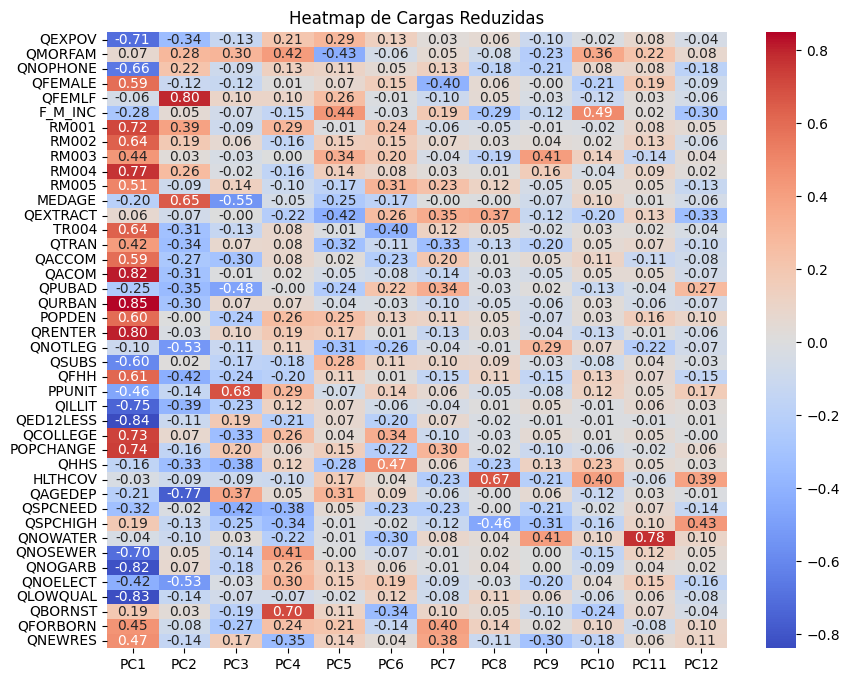

In [9]:
# Quando rodar essa parte, escreva um valor de 0 a 100 para variância limite.
limite = int(input('Digite o limite da variância (inteiro, último valor não incluso): '))
componentes_corte = variancia_df.index[variancia_df["Acumulada (%)"] < limite]
print(componentes_corte)

# 2️⃣ Selecionar essas colunas no cargas_df
cargas_reduzidas = df_loadings.iloc[:, componentes_corte]

print("Número de componentes mantidos:", len(componentes_corte))
plt.figure(figsize=(10,8))  # Define o tamanho da figura
sns.heatmap(cargas_reduzidas, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Heatmap de Cargas Reduzidas")
plt.show()

In [10]:
threshold = 0.5
result = {}

for col in cargas_reduzidas.columns:
    # Filtra as linhas onde o valor está abaixo de -0.5 ou acima de 0.5
    mask = (cargas_reduzidas[col] < -threshold) | (cargas_reduzidas[col] > threshold)
    filtered = cargas_reduzidas[col][mask]

    # Ordena pela ordem decrescente do módulo
    filtered = filtered.reindex(filtered.abs().sort_values(ascending=False).index)

    # Adiciona ao dicionário
    result[col] = filtered

# Mostrando o resultado
for col, series in result.items():
    print(f"\nColuna: {col}")
    print(series)


Coluna: PC1
QURBAN       0.849830
QED12LESS   -0.838858
QLOWQUAL    -0.825839
QACOM        0.816374
QNOGARB     -0.815568
QRENTER      0.804518
RM004        0.769098
QILLIT      -0.745345
POPCHANGE    0.739762
QCOLLEGE     0.728671
RM001        0.717808
QEXPOV      -0.705769
QNOSEWER    -0.703729
QNOPHONE    -0.660874
RM002        0.638211
TR004        0.635123
QFHH         0.614269
QSUBS       -0.599922
POPDEN       0.597652
QFEMALE      0.590585
QACCOM       0.590337
RM005        0.508962
Name: PC1, dtype: float64

Coluna: PC2
QFEMLF      0.795572
QAGEDEP    -0.770276
MEDAGE      0.653978
QNOTLEG    -0.529683
QNOELECT   -0.525060
Name: PC2, dtype: float64

Coluna: PC3
PPUNIT    0.681040
MEDAGE   -0.547146
Name: PC3, dtype: float64

Coluna: PC4
QBORNST    0.704209
Name: PC4, dtype: float64

Coluna: PC5
Series([], Name: PC5, dtype: float64)

Coluna: PC6
Series([], Name: PC6, dtype: float64)

Coluna: PC7
Series([], Name: PC7, dtype: float64)

Coluna: PC8
HLTHCOV    0.666864
Name: PC8, 

In [11]:
# Lista das colunas que têm pelo menos 1 valor e converte PC para F
colunas_com_valores = [col for col, series in result.items() if not series.empty]
colunas_convertidas = [c.replace("PC", "F") for c in colunas_com_valores]

In [12]:
var_positivo = [
    'QEXPOV','QMORFAM','QNOPHONE','QURBAN','POPDEN','QRENTER','QNOTLEG',
    'QSUBS','QFHH','PPUNIT','QILLIT','QED12LESS','POPCHANGE','QAGEDEP',
    'QSPCNEED','QSPCHIGH','QNOWATER','QNOSEWER','QNOGARB','QNOELECT',
    'QLOWQUAL','QBORNST','QFORBORN','QNEWRES'
]

var_negativo = [
    'QFEMLF','F_M_INC','RM001','RM002','RM003','RM004','RM005',
    'QLEGWO','QCOLLEGE','QHHS','HLTHCOV'
]

var_neutro = [
    'QWHITE','QBLACK','QASIAN','QPARDO','QINDIAN','MEDAGE','QAGRI',
    'QEXTRACT','TR004','TR005','QTRAN','QACCOM','QACOM','QPUBAD','QFEMALE'
]

In [13]:
colunas_inverter = []   # guardará os nomes tipo "F8", "F2", etc.

for pc, series in result.items():
    if series.empty:
        continue
    # variável de maior valor absoluto
    var_top = series.abs().idxmax()
    if var_top in var_negativo:
        # transforma PCx em Fx (mesmo número)
        fator = pc.replace("PC", "F")
        colunas_inverter.append(fator)

print("Colunas a multiplicar por -1:", colunas_inverter)

Colunas a multiplicar por -1: ['F2', 'F8']


In [15]:
# 4. Criar DataFrame de scores
scores_df = pd.DataFrame(
    scores_r1[:, :len(componentes_corte)],
    index=dados_finais_para_PCA.index,
    columns=[f"F{i+1}" for i in range(len(componentes_corte))]
)
scores_selecionado = scores_df[colunas_convertidas]

for f in colunas_inverter:
    scores_selecionado[f] *= -1

# 5. Calcular média
scores_selecionado["MÉDIA"] = scores_selecionado.mean(axis=1)
display(scores_selecionado.head(10))

/tmp/ipython-input-3252484479.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_selecionado[f] *= -1
/tmp/ipython-input-3252484479.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_selecionado["MÉDIA"] = scores_selecionado.mean(axis=1)


F1        F2        F3        F4        F8       F11     MÉDIA
0 -4.571052  1.163831 -1.660978  0.506924 -0.163505 -0.943171 -0.944659
1 -2.579279  2.929439  0.920925  2.415858 -0.061190  0.374269  0.666670
2  1.663951 -0.654924  1.376581 -2.163512  1.287007 -0.585930  0.153862
3 -0.209525 -1.393308  0.951769 -1.920318  0.504771  0.049163 -0.336241
4 -1.649500  0.531340  0.032473 -0.318966  0.390483 -0.455145 -0.244886
5 -0.792446  0.315230 -0.930468  0.383133 -0.818089  0.377707 -0.244155
6 -2.495980 -1.291597 -0.612891  1.014742  0.191332 -0.428219 -0.603769
7 -0.114650 -1.656900  0.934348 -0.791576 -0.664235 -0.451830 -0.457474
8 -2.811603 -0.053498 -0.091206 -2.225934 -0.257422  1.626407 -0.635543
9 -3.021551 -3.664952 -3.011373 -1.233294  1.294077  0.702391 -1.489117

## Mapa final

In [16]:
identificadores_com_media = identificadores.join(
    scores_selecionado['MÉDIA']
)
display(identificadores_com_media)

GEOCOD           MUNI     MÉDIA
0    4200051  Abdon Batista -0.944659
1    4200101   Abelardo Luz  0.666670
2    4200200     Agrolândia  0.153862
3    4200309     Agronômica -0.336241
4    4200408      Água Doce -0.244886
..       ...            ...       ...
288  4219408      Witmarsum -0.444493
289  4219507        Xanxerê  1.028391
290  4219606      Xavantina -0.489662
291  4219705          Xaxim  0.659984
292  4219853         Zortéa -0.387525

[293 rows x 3 columns]

In [17]:
from geobr import read_municipality
import folium
from folium.features import GeoJsonTooltip
import numpy as np

# === 1. Shape de SC ===
sc_shp = read_municipality(code_muni=42, year=2010)
sc_shp["code_muni"] = sc_shp["code_muni"].apply(lambda x: str(int(x)).zfill(7))

# === 2. Dados com GEOCOD + MÉDIA ===
df_media = identificadores_com_media.copy()
df_media["code_muni"] = df_media["GEOCOD"].astype(str).str.zfill(7)

# === 3. Merge shape + dados ===
mapa_media = sc_shp.merge(df_media, on="code_muni", how="left")

print("Municípios com correspondência:",
      mapa_media["MÉDIA"].notna().sum())

# === 4. Calcula bins automáticos ===
vmin = mapa_media["MÉDIA"].min()
vmax = mapa_media["MÉDIA"].max()
# cria 8 faixas uniformes (pode ajustar n° de bins se desejar)
threshold_scale = list(np.linspace(vmin, vmax, 8))

# === 5. Mapa interativo ===
m = folium.Map(location=[-27.3, -50.7],
               zoom_start=7,
               tiles="CartoDB positron")

folium.Choropleth(
    geo_data=mapa_media,
    data=mapa_media,
    columns=["code_muni", "MÉDIA"],
    key_on="feature.properties.code_muni",
    fill_color="RdYlGn_r",
    fill_opacity=0.8,
    line_color="white",
    line_opacity=0.1,
    line_weight=0.3,
    threshold_scale=threshold_scale,
    legend_name="Média – SC"
).add_to(m)

tooltip = GeoJsonTooltip(
    fields=["name_muni", "MÉDIA"],
    aliases=["Município:", "Média:"],
    localize=True
)

folium.GeoJson(
    data=mapa_media,
    tooltip=tooltip,
    name="Municípios",
    style_function=lambda x: {
        "fillOpacity": 0,
        "weight": 0.3,
        "color": "white"
    }
).add_to(m)

m.save("Mapa_Media_SC.html")
print("✅ Mapa gerado com sucesso.")
m

Municípios com correspondência: 293
✅ Mapa gerado com sucesso.
